# Inpainting 2

In [4]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from ultralytics import YOLO
import model_loader
from transformers import CLIPTokenizer

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")

MASKPATH = "../mask/"
os.makedirs(MASKPATH, exist_ok=True)

# --- Caricamento modelli ---
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

# --- Caricamento immagine ---
img_path = "../images/frame_10500ms.jpg"
assert os.path.exists(img_path), f"Immagine non trovata: {img_path}"
img = cv2.imread(img_path)
img = cv2.resize(img, (1280, 720))
height, width = img.shape[:2]
original_img = Image.open(img_path).convert("RGB").resize((1280, 720))
output_img = original_img.copy()

# --- Segmentazione con YOLOv8 ---
print("\n[INFO] Segmentazione con YOLOv8...")
start_yolo_seg = time.time()
model = YOLO("yolov8x-seg.pt")
results = model(img, task="segment", verbose=False)
yolo_seg_time = time.time() - start_yolo_seg

# # --- YOLOv8 Pose ---
# start_yolo_pose = time.time()
# model_pose = YOLO("yolov8x-pose.pt")
# yolo_pose_time = time.time() - start_yolo_pose
# print("Informazioni rilevati con 'YOLOv8 Pose'")
# print(model_pose.info)

# --- Estrazione maschere ---
mask = np.zeros((height, width), dtype=np.uint8)
segments = []
target_classes = [0, 2, 3]

for result in results:
    boxes = result.boxes
    masks = result.masks
    if masks is not None:
        for i, cls_id in enumerate(boxes.cls):
            if int(cls_id) in target_classes:
                m = masks.data[i].cpu().numpy().astype(np.uint8)
                m_resized = cv2.resize(m, (width, height), interpolation=cv2.INTER_NEAREST)
                mask[m_resized == 1] = 255
                x1, y1, x2, y2 = map(int, boxes.xyxy[i].cpu().numpy())
                segments.append((x1, y1, x2, y2, int(cls_id), m_resized))

cv2.imwrite(MASKPATH + "mask_completa.png", mask)



[INFO] Using device: cuda

[INFO] Segmentazione con YOLOv8...


True


[INFO] Avvio inpainting per oggetto...
[INFO] Oggetto 3/15: (925, 455, 999, 644)
[INFO] prompt:realistic anonymized people in same position and appearance, photorealistic, same background


100%|██████████| 47/47 [00:03<00:00, 15.10it/s]


[INFO] Inpainting completato in 4.84 secondi.


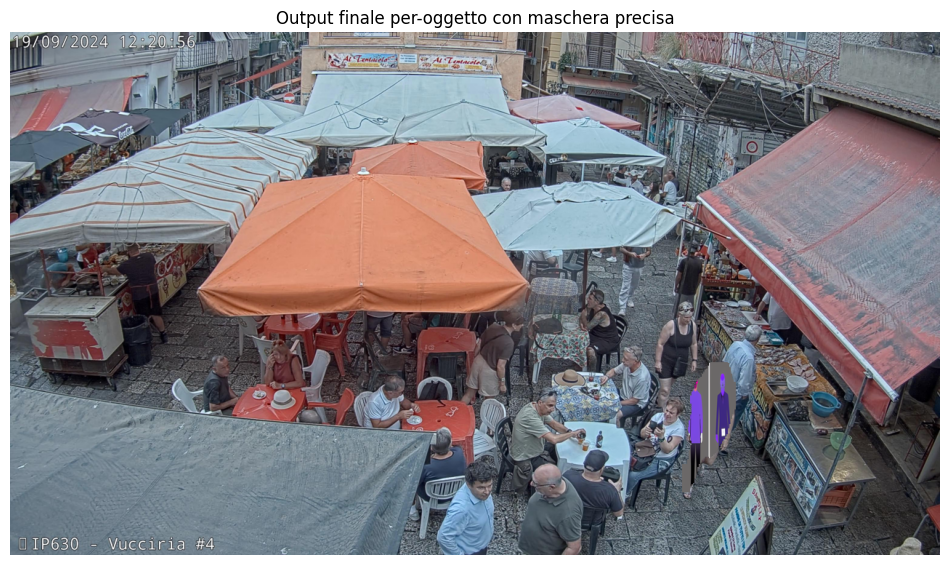

[INFO] Risultato salvato in: ../images/output_per_object_precise.jpg
[INFO] CSV salvato in ../dataFrame/tempi_inpainting.csv


In [3]:
import pipeline
import importlib
importlib.reload(pipeline)

prompt_dict = {
    0: "realistic anonymized people in same position and appearance, photorealistic, same background",
    2: "realistic anonymized vehicles in same position and appearance, photorealistic, same background",
    3: "realistic anonymized motorcycle in same position and appearance, photorealistic, same background"
}

uncond_prompt = ""
strength = 0.95
cfg_scale = 7.5
sampler = "ddpm"
n_steps = 50

print("\n[INFO] Avvio inpainting per oggetto...")
start_time_total = time.time()
start_inpainting = time.time()

for i, (x1, y1, x2, y2, cls_id, m_object) in enumerate(segments):
    if i == 2:
        print(f"[INFO] Oggetto {i+1}/{len(segments)}: ({x1}, {y1}, {x2}, {y2})")
        cropped_img = original_img.crop((x1, y1, x2, y2))
        mask_crop_np = m_object[y1:y2, x1:x2] * 255
        cv2.imwrite(MASKPATH + f"{i}_mask_crop_img.png", mask_crop_np)
        cropped_img.save(MASKPATH + f"{i}_cropped_img.png")

        if np.sum(mask_crop_np) == 0:
            print(f"[WARNING] Maschera vuota per oggetto {i+1}, salto...")
            continue

        mask_crop = Image.fromarray(mask_crop_np.astype(np.uint8)).convert("L")
        resized_crop = ImageOps.fit(cropped_img, (512, 512), method=Image.Resampling.LANCZOS)
        resized_mask = ImageOps.fit(mask_crop, (512, 512), method=Image.Resampling.LANCZOS).convert("L")

        print(f"[INFO] prompt:{prompt_dict[cls_id]}")
        result = pipeline.generate(
            prompt=prompt_dict[cls_id],
            uncond_prompt=uncond_prompt,
            input_image=resized_crop,
            input_mask=resized_mask,
            strength=strength,
            do_cfg=True,
            cfg_scale=cfg_scale,
            sampler_name=sampler,
            n_inference_steps=n_steps,
            seed=None,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer
        )

        cv2.imwrite(MASKPATH + f"{i}_new_img.png", result)
        result_resized = Image.fromarray(result).resize((x2 - x1, y2 - y1), resample=Image.Resampling.LANCZOS)
        result_np = np.array(result_resized)

        mask_np = np.array(mask_crop.resize((x2 - x1, y2 - y1))).astype(np.uint8) / 255.0
        mask_np = np.expand_dims(mask_np, axis=-1)

        blended_np = np.array(output_img.crop((x1, y1, x2, y2))).astype(np.float32)
        blended_np = result_np.astype(np.float32) * mask_np + blended_np * (1 - mask_np)
        blended_img = Image.fromarray(np.uint8(blended_np.clip(0, 255)))

        output_img.paste(blended_img, (x1, y1))

inpainting_time = time.time() - start_inpainting
end_time_total = time.time()

print(f"[INFO] Inpainting completato in {end_time_total - start_time_total:.2f} secondi.")

# --- Visualizzazione e salvataggio ---
plt.figure(figsize=(12, 10))
plt.imshow(output_img)
plt.title("Output finale per-oggetto con maschera precisa")
plt.axis("off")
plt.show()

output_path = "../images/output_per_object_precise.jpg"
output_img.save(output_path)
print(f"[INFO] Risultato salvato in: {output_path}")

# --- Salvataggio tempi in CSV ---
import pandas as pd

os.makedirs("../dataFrame", exist_ok=True)
df = pd.DataFrame([{
    "Nome del modello": "Stable Diffusion v1.5",
    "Tempo YOLO Segmentazione": round(yolo_seg_time, 2),
    "Tempo YOLO Pose": round(yolo_pose_time, 2),
    "Tempo Inpainting per Oggetto": round(inpainting_time, 2),
    "Tempo Totale": round(end_time_total - start_time_total, 2)
}])

df.to_csv("../dataFrame/tempi_inpainting.csv", index=False)
print("[INFO] CSV salvato in ../dataFrame/tempi_inpainting.csv")

# Inpainting 3

[INFO] Using device: cuda

[INFO] Segmentazione con YOLOv8...

[INFO] Avvio inpainting completo immagine...
WIDTH, HEIGHT, LATENTS_WIDTH, LATENTS_HEIGHT: 512 512 64 64
pipeline.py - input_image passata


100%|██████████| 47/47 [00:03<00:00, 14.92it/s]


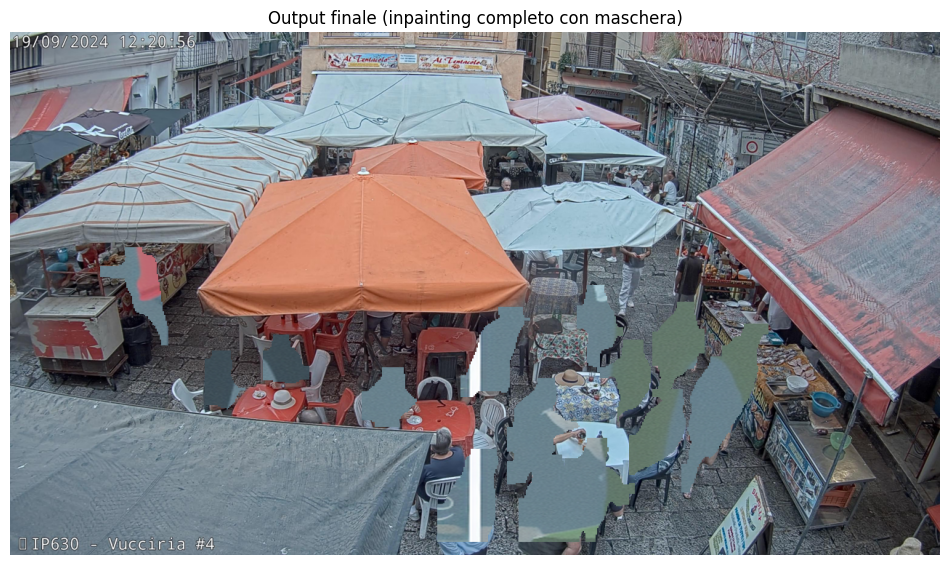

[INFO] Risultato salvato in: ../images/output_full_image_inpainting.jpg
[INFO] CSV salvato in ../dataFrame/tempi_inpainting.csv


In [7]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline
import importlib
importlib.reload(pipeline)

# === Configurazione ambiente ===
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")

# === Percorsi e setup ===
IMG_PATH = "../images/frame_10500ms.jpg"
MASKPATH = "../mask/"
os.makedirs(MASKPATH, exist_ok=True)
os.makedirs("../dataFrame", exist_ok=True)

# === Caricamento modelli ===
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

# === Caricamento immagine ===
assert os.path.exists(IMG_PATH), f"Immagine non trovata: {IMG_PATH}"
img = cv2.imread(IMG_PATH)
img = cv2.resize(img, (1280, 720))
height, width = img.shape[:2]
original_img = Image.open(IMG_PATH).convert("RGB").resize((width, height))
output_img = original_img.copy()

# === Segmentazione YOLOv8 ===
print("\n[INFO] Segmentazione con YOLOv8...")
start_yolo_seg = time.time()
yolo_model = YOLO("yolov8x-seg.pt")
results = yolo_model(img, task="segment", verbose=False)
yolo_seg_time = time.time() - start_yolo_seg

# === Estrazione maschere ===
mask = np.zeros((height, width), dtype=np.uint8)
target_classes = [0, 2, 3]  # persona, auto, moto

for result in results:
    boxes = result.boxes
    masks = result.masks
    if masks is not None:
        for i, cls_id in enumerate(boxes.cls):
            if int(cls_id) in target_classes:
                m = masks.data[i].cpu().numpy().astype(np.uint8)
                m_resized = cv2.resize(m, (width, height), interpolation=cv2.INTER_NEAREST)
                mask[m_resized == 1] = 255

cv2.imwrite(MASKPATH + "mask_completa.png", mask)

# === Prepara input per inpainting ===
resized_img = ImageOps.fit(original_img, (512, 512), method=Image.Resampling.LANCZOS)
resized_mask = ImageOps.fit(Image.fromarray(mask), (512, 512), method=Image.Resampling.LANCZOS).convert("L")

prompt = (
    "a person same position and clothes, "
    "photorealistic, same background"
)

# === Inpainting su immagine intera ===
print("\n[INFO] Avvio inpainting completo immagine...")
start_inpainting = time.time()

result = pipeline.generate(
    prompt=prompt,
    uncond_prompt="",
    input_image=resized_img,
    input_mask=resized_mask,
    strength=0.95,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    seed=None,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer
)

inpainting_time = time.time() - start_inpainting

# === Fusione risultato con immagine originale ===
result_img = Image.fromarray(result).resize((width, height), resample=Image.Resampling.LANCZOS)
mask_np = np.array(mask).astype(np.float32) / 255.0
mask_np = np.expand_dims(mask_np, axis=-1)
original_np = np.array(original_img).astype(np.float32)
result_np = np.array(result_img).astype(np.float32)

result_img.save(MASKPATH + "result_img.png")

blended_np = result_np * mask_np + original_np * (1 - mask_np)
output_img = Image.fromarray(np.uint8(blended_np.clip(0, 255)))

# === Visualizzazione e salvataggio ===
plt.figure(figsize=(12, 10))
plt.imshow(output_img)
plt.title("Output finale (inpainting completo con maschera)")
plt.axis("off")
plt.show()

output_path = "../images/output_full_image_inpainting.jpg"
output_img.save(output_path)
print(f"[INFO] Risultato salvato in: {output_path}")

# === Salvataggio tempi in CSV ===
df = pd.DataFrame([{
    "Nome del modello": "Stable Diffusion v1.5",
    "Tempo YOLO Segmentazione": round(yolo_seg_time, 2),
    "Tempo Inpainting Intero": round(inpainting_time, 2),
    "Tempo Totale": round(yolo_seg_time + inpainting_time, 2)
}])
df.to_csv("../dataFrame/tempi_inpainting.csv", index=False)
print("[INFO] CSV salvato in ../dataFrame/tempi_inpainting.csv")


[INFO] Using device: cuda

[INFO] Segmentazione con YOLOv8...
sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.27it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.28it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.27it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.26it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.24it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.22it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.30it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.26it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.24it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.23it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.23it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.26it/s]


sono in pipeline.generate() ed sto per elaborare la chiave diffusion


100%|██████████| 15/15 [00:00<00:00, 15.21it/s]


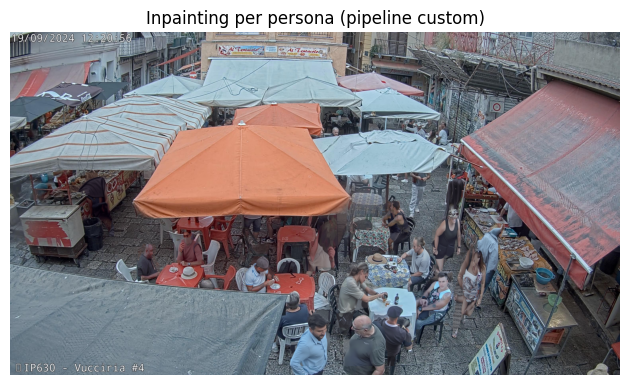

[INFO] CSV salvato in: ../dataFrame/tempi_inpainting_custom.csv
[✅] 16 persone elaborate


In [5]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline
import importlib
importlib.reload(pipeline)

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")

# === Percorsi ===
IMG_PATH = "../images/frame_10500ms.jpg"
OUT_PATH = "../images/output_custom_inpainting.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom.csv"

os.makedirs("../images", exist_ok=True)
os.makedirs("../dataFrame", exist_ok=True)

# === Caricamento modelli ===
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

# === Caricamento immagine ===
assert os.path.exists(IMG_PATH), f"Immagine non trovata: {IMG_PATH}"
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === Segmentazione YOLOv8 ===
print("\n[INFO] Segmentazione con YOLOv8...")
start_yolo = time.time()
yolo_model = YOLO("yolov8x-seg.pt")
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0

for result in results:
    boxes = result.boxes
    masks = result.masks
    if masks is None:
        continue

    for i, cls_id in enumerate(boxes.cls):
        if int(cls_id) != 0:
            continue  # solo persone

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks.data[i].cpu().numpy().astype(np.uint8)
        mask_resized = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
        contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled = np.zeros_like(mask_resized)
        cv2.drawContours(mask_filled, contours, -1, 255, thickness=cv2.FILLED)

        mask_area = mask_filled[y1:y2, x1:x2].sum()
        if mask_area < 200:
            continue

        crop_img = original_img.crop((x1, y1, x2, y2))
        crop_mask = Image.fromarray(mask_filled[y1:y2, x1:x2]).convert("L")

        resized_img = crop_img.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask = crop_mask.resize((512, 512), resample=Image.Resampling.NEAREST)

        prompt = "realistic person, same pose, same clothes, full body, high quality"
        negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"

        start_inpaint = time.time()
        result = pipeline.generate(
            prompt=prompt,
            uncond_prompt=negative_prompt,
            input_image=resized_img,
            input_mask=resized_mask,
            strength=0.5,
            do_cfg=True,
            cfg_scale=7.5,
            sampler_name="ddpm",
            n_inference_steps=30,
            seed=None,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer
        )
        inpaint_time = time.time() - start_inpaint
        inpaint_total_time += inpaint_time

        result_img = Image.fromarray(result).resize((box_w, box_h), resample=Image.Resampling.LANCZOS)
        result_np = np.array(result_img).astype(np.float32)
        crop_np = np.array(crop_img).astype(np.float32)
        mask_np = np.array(crop_mask.resize((box_w, box_h))).astype(np.float32) / 255.0
        mask_np = np.expand_dims(mask_np, axis=-1)

        blended = result_np * mask_np + crop_np * (1 - mask_np)
        final_img_np[y1:y2, x1:x2] = blended.astype(np.uint8)
        crop_counter += 1

# === Salvataggio risultato finale ===
final_img = Image.fromarray(final_img_np)
final_img.save(OUT_PATH)

plt.imshow(final_img)
plt.title("Inpainting per persona (pipeline custom)")
plt.axis("off")
plt.tight_layout()
plt.show()

# === Salvataggio tempi ===
df = pd.DataFrame([{
    "Modello": "YOLOv8-seg + Custom SD 1.5",
    "Tempo YOLO": round(yolo_time, 2),
    "Tempo Inpainting": round(inpaint_total_time, 2),
    "Tempo Totale": round(yolo_time + inpaint_total_time, 2),
    "Persone elaborate": crop_counter
}])
df.to_csv(CSV_PATH, index=False)
print(f"[INFO] CSV salvato in: {CSV_PATH}")
print(f"[✅] {crop_counter} persone elaborate")

# v1-5-pruned-emaonly-fp16.ckpt

/home/vs/Projects/pytorch-stable-diffusion/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Using device: cuda

[INFO] Segmentazione con YOLOv8...
sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:01<00:00, 14.95it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.50it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.44it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.38it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.52it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.47it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.45it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.45it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.43it/s]


sono in pipeline.generate() e sto per elaborare la chiave [diffusion]


100%|██████████| 15/15 [00:00<00:00, 15.41it/s]


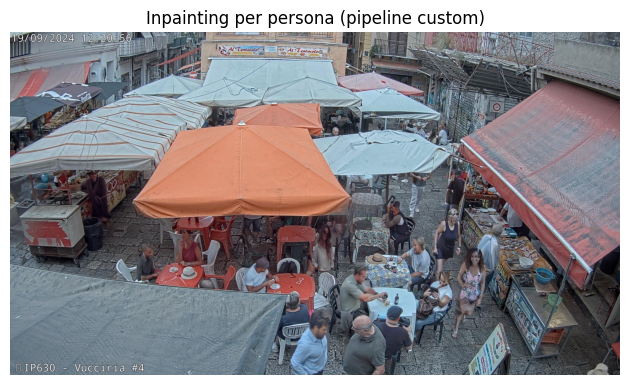

[INFO] CSV salvato in: ../dataFrame/tempi_inpainting_custom_fp16.csv
[✅] 16 persone elaborate


In [1]:
import os
import time
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from ultralytics import YOLO
from transformers import CLIPTokenizer

import model_loader
import pipeline
import importlib
importlib.reload(pipeline)

# === Config ===
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {DEVICE}")

# === Percorsi ===
IMG_PATH = "../images/frame_10500ms.jpg"
OUT_PATH = "../images/output_custom_inpainting_fp16.jpg"
CSV_PATH = "../dataFrame/tempi_inpainting_custom_fp16.csv"

os.makedirs("../images", exist_ok=True)
os.makedirs("../dataFrame", exist_ok=True)

# === Caricamento modelli ===
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly-fp16.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

# === Caricamento immagine ===
assert os.path.exists(IMG_PATH), f"Immagine non trovata: {IMG_PATH}"
original_img = Image.open(IMG_PATH).convert("RGB")
img_np = np.array(original_img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
img_height, img_width = img_np.shape[:2]

# === Segmentazione YOLOv8 ===
print("\n[INFO] Segmentazione con YOLOv8...")
start_yolo = time.time()
yolo_model = YOLO("yolov8x-seg.pt")
results = yolo_model(img_cv, task="segment", verbose=False)
yolo_time = time.time() - start_yolo

final_img_np = img_np.copy().astype(np.uint8)
crop_counter = 0
inpaint_total_time = 0

for result in results:
    boxes = result.boxes
    masks = result.masks
    if masks is None:
        continue

    for i, cls_id in enumerate(boxes.cls):
        if int(cls_id) != 0:
            continue  # solo persone

        x1, y1, x2, y2 = boxes.xyxy[i].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(img_width, x2), min(img_height, y2)
        box_w, box_h = x2 - x1, y2 - y1

        if box_w < 30 or box_h < 30:
            continue

        mask_raw = masks.data[i].cpu().numpy().astype(np.uint8)
        mask_resized = cv2.resize(mask_raw, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
        contours, _ = cv2.findContours(mask_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        mask_filled = np.zeros_like(mask_resized)
        cv2.drawContours(mask_filled, contours, -1, 255, thickness=cv2.FILLED)

        mask_area = mask_filled[y1:y2, x1:x2].sum()
        if mask_area < 200:
            continue

        crop_img = original_img.crop((x1, y1, x2, y2))
        crop_mask = Image.fromarray(mask_filled[y1:y2, x1:x2]).convert("L")

        resized_img = crop_img.resize((512, 512), resample=Image.Resampling.LANCZOS)
        resized_mask = crop_mask.resize((512, 512), resample=Image.Resampling.NEAREST)

        prompt = "realistic person, same pose, same clothes, full body, high quality"
        negative_prompt = "cartoon, anime, distorted, glitch, unrealistic, deformed"

        start_inpaint = time.time()
        result = pipeline.generate(
            prompt=prompt,
            uncond_prompt=negative_prompt,
            input_image=resized_img,
            input_mask=resized_mask,
            strength=0.5,
            do_cfg=True,
            cfg_scale=7.5,
            sampler_name="ddpm",
            n_inference_steps=30,
            seed=None,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer
        )
        inpaint_time = time.time() - start_inpaint
        inpaint_total_time += inpaint_time

        result_img = Image.fromarray(result).resize((box_w, box_h), resample=Image.Resampling.LANCZOS)
        result_np = np.array(result_img).astype(np.float32)
        crop_np = np.array(crop_img).astype(np.float32)
        mask_np = np.array(crop_mask.resize((box_w, box_h))).astype(np.float32) / 255.0
        mask_np = np.expand_dims(mask_np, axis=-1)

        blended = result_np * mask_np + crop_np * (1 - mask_np)
        final_img_np[y1:y2, x1:x2] = blended.astype(np.uint8)
        crop_counter += 1

# === Salvataggio risultato finale ===
final_img = Image.fromarray(final_img_np)
final_img.save(OUT_PATH)

plt.imshow(final_img)
plt.title("Inpainting per persona (pipeline custom)")
plt.axis("off")
plt.tight_layout()
plt.show()

# === Salvataggio tempi ===
df = pd.DataFrame([{
    "Modello": "YOLOv8-seg + Custom SD 1.5 fp16",
    "Tempo YOLO": round(yolo_time, 2),
    "Tempo Inpainting": round(inpaint_total_time, 2),
    "Tempo Totale": round(yolo_time + inpaint_total_time, 2),
    "Persone elaborate": crop_counter
}])
df.to_csv(CSV_PATH, index=False)
print(f"[INFO] CSV salvato in: {CSV_PATH}")
print(f"[✅] {crop_counter} persone elaborate")